In [111]:
import warnings
warnings.filterwarnings("ignore")

In [112]:
# Useful libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Useful metrics
import time
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import trange

In [113]:
# Function to get time statistics
def time_stats(start, end):
    elapsed = end - start
    mins = int(elapsed / 60)            # Get minutes
    secs = (elapsed - (mins * 60))      # Get seconds
    return mins, secs

# MNIST Dataset

First we import the dataset using torchvision. 

We can directly divide them into training and testing datasets by changing the *train* parameter. 

The *MNIST* class returns a list of tuples of the form *(PIL image, label)*. There are 60,000 train and 10,000 test images. 

The test dataset is also labelled.

In [114]:
from torchvision.datasets import MNIST

# Importing training and testing data from torchvision dataset collection
train_data = MNIST(root='./data', download=True, train=True, transform=None)
test_data = MNIST(root='./data', download=True, train=False, transform=None)

print(f"Number of Train images:\t {len(train_data)}")
print(f"Number of Test images:\t {len(test_data)}")

Number of Train images:	 60000
Number of Test images:	 10000


## MNIST Example

Let us take a look a how the image looks like. Each image is $(28\times 28)$ 2D array of integers ranging from 0 to 255. 

Notice that the image is not in grayscale because matplotlib assumes the input to be a colored

Shape: (28, 28)


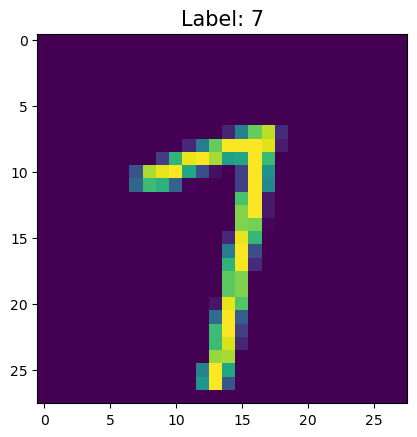

In [115]:
# Separate out image and its label
img, label = train_data[42]

print(f"Shape: {np.asarray(img).shape}")

# Plotting the image
plt.figure()
plt.imshow(img)
plt.title(f"Label: {label}", fontsize=15)
plt.show()

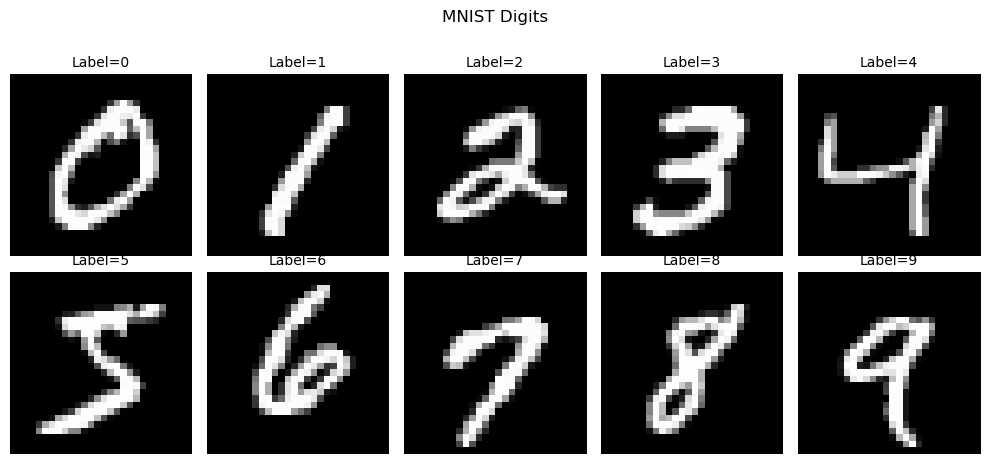

In [116]:
# Storing the indices of respective digits in training dataset
unique_ids = [1, 3, 5, 7, 2, 0, 13, 15, 17, 4]

# Plotting all digits in a 2x5 grid
plt.figure(figsize=(10,5))
for i,idx in enumerate(unique_ids):
    i = i + 1
    ax1 = plt.subplot(2, 5, i)
    plt.axis('off')
    ax1.imshow(train_data[idx][0], plt.cm.gray)
    ax1.set_aspect('equal')
    ax1.set_title(f'Label={i-1}', fontsize=10)
plt.subplots_adjust(wspace=0.1, hspace=0, top=1)
plt.suptitle('MNIST Digits')
plt.tight_layout()
plt.show()

## Data Preprocessing

To use the dataset, we must do the following:
1. Split the tuple into features-$X$ and labels-$Y$
2. Since the input is a 2D array, flatten each image to 1D array of length $784 = (28 \times 28)$
3. Convert *train_data* and *test_data* into iterable lists of float type

### Format of the Datasets:

*X_train* : $60,000\times784$ numpy array of flattened versions of training images

*Y_train* : $1\times60,000$ numpy array of the true labels of the corresponding training images

*X_test* : $10,000\times784$ numpy array of flattened versions of test images

*Y_test* : $1\times10,000$ numpy array of the true labels of the corresponding test images

In [117]:
# Splitting train and test datasets
# Convert pixel values to float
X_train = [np.asarray(img).flatten().astype(np.float32) for img,label in train_data]
Y_train = [label for img,label in train_data]

X_test = [np.asarray(img).flatten().astype(np.float32) for img,label in test_data]
Y_test = [label for img,label in test_data]

In [118]:
# Normalizing the Images
X_train = [(img-np.mean(img))/np.std(img) for img in X_train]
X_test = [(img-np.mean(img))/np.std(img) for img in X_test]

In [119]:
# Converting to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

## Neural Network

### Layers
We define the neural network model as series of layers, with forward and backpropagation functions. The forward function takes an input $x$ of size *batch_size $\times$ input_dim*, and backward function takes the upstream gradient. A multi-layer perceptron will have layers of three types:
- **FullyConnected:** The main layer that performs the transformation $xW + B$
- **ReLU:** The activation layer that applies the ReLU function $max(0,x)$
- **SoftmaxCrossEntropy:** The final layer that computes Softmax and Cross Entropy loss

### Dummy Layer
We first define a dummy Layer class. Each specific layer will be an instance of this class.
- **Forward:** Just returns the input $x$
- **Backward:** Returns the upstream gradient 

In [120]:
class Layer():
    def __init__(self):
        pass

    def forward(self, x):
        return x
    
    def backward(self, x, up_grad):
        idt_mat = np.eye(x.shape[1])    # identity matrix
        return np.dot(up_grad, idt_mat)

### Fully Connected
The fully connected layer will have input dimensions, output dimensions and learning rate as parameters. 
It randomly initializes the weights and, bias with zeroes.
- **Forward:** Returns the transformation $xW+B$
- **Backward:** Returns the gradient of input $dx$, and updates $W$ and $B$

In [121]:
class FullyConnected(Layer):
    def __init__(self, in_dim, out_dim, lr=1.0):
        super().__init__()
        self.in_dim = in_dim        # Input dimension
        self.out_dim = out_dim      # Output dimension
        self.lr = lr                # Learning rate

        # Initializing weights and bias
        np.random.seed(42)
        self.weights = 1e-2 * np.random.randn(in_dim,out_dim)
        self.bias = np.zeros(out_dim)
    
    def forward(self, x):
        return np.dot(x, self.weights) + self.bias
    
    def backward(self, x, up_grad):
        dx = np.dot(up_grad, self.weights.T)        # df/dx
        
        dW = np.dot(x.T, up_grad)                   # df/dW
        db = up_grad.mean(axis=0) * x.shape[0]      # df/dB
        
        assert dW.shape == self.weights.shape and db.shape == self.bias.shape
        
        # Update weights and biases
        self.weights = self.weights - self.lr * dW
        self.bias = self.bias - self.lr * db
        
        return dx


### ReLU
The relu layer will have no parameters, since it only performs the $max$ function. 
- **Forward:** Returns the transformation $max(0,x)$
- **Backward:** Returns the gradient of input $dx$ if $x>0$

In [122]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return np.maximum(0, x)     # max(0,x)
    
    def backward(self, x, up_grad):
        relu_grad = x > 0
        return up_grad * relu_grad

### Softmax and Cross Entropy (SCE)
The SCE layer will have no parameters, but will contain the function $softmax$ to calculate softmax values, $s$. 
The functions also take the labels $Y$ as an argument.
- **Forward:** Returns the cross entropy loss
- **Backward:** Returns the softmax cross entropy loss equal to $s-y$

In [123]:
class SoftmaxCrossEntropy(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, x, y_true):
        smax = self.softmax(x)          # softmax scores
        batch_size = y_true.shape[0]    # number of inputs or batch size
        
        log_likelihood = -np.log(smax[range(batch_size), y_true])   # log likelihood
        loss = np.sum(log_likelihood) / batch_size                  # average loss
        return loss
    
    def backward(self, x, y_true):
        batch_size = y_true.shape[0]    # number of inputs or batch size
        grad = self.softmax(x)          # softmax scores

        grad[range(batch_size), y_true] -= 1    # df/dsce = s-y
        grad = grad / batch_size
        return grad
    
    # Function to get softmax scores
    def softmax(self, x):
        exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

### Model
Let us define the model as a list of layers starting with the input layer and ending with SCE layer.

In [124]:
model = []

model.append(FullyConnected(784, 200, lr=0.01))     # xW1 + B1
model.append(ReLU())                                # Relu(xW1+B1)

model.append(FullyConnected(200, 50, lr=0.01))      # xW2 + B2
model.append(ReLU())                                # Relu(xW2+B2)

model.append(FullyConnected(50, 10, lr=0.01))       # xW3 + B3
model.append(SoftmaxCrossEntropy())

# Storing the model size without the loss layer
model_size = len(model) - 1
print(f"Model Size: {model_size}")

Model Size: 5


In [125]:
# Weights and biases
print(f"W_1: {model[0].weights.shape}")
print(f"B_1: {model[0].bias.shape}\n")

print(f"W_2: {model[2].weights.shape}")
print(f"B_2: {model[2].bias.shape}\n")

print(f"W_3: {model[4].weights.shape}")
print(f"B_3: {model[4].bias.shape}")

W_1: (784, 200)
B_1: (200,)

W_2: (200, 50)
B_2: (50,)

W_3: (50, 10)
B_3: (10,)


### Train
Define a training loop that will run forward prop then backward prop for one step. This training loop will called for each batch.

Define a predict function that predicts the class given an input image of size 784. For our purpose, it also takes in true labels $Y$ and returns the loss.

Define a batch iterator that divides the input dataset to batches and takes shuffle as an argument

In [126]:
# Training loop for training
def train_loop(model, x, Y):
    model_size = len(model)-1       # Get model size to separate last layer from model

    # Forward prop
    out = [x]
    for i in range(model_size):
        out.append(model[i].forward(out[-1]))
    loss = model[-1].forward(out[-1],Y)

    # Backprop
    upgrad = [model[-1].backward(out[-1], Y)]
    for i in reversed(range(model_size)):
        upgrad.append(model[i].backward(out[i], upgrad[-1]))
    
    return loss

In [127]:
# Prediction function
def predict(model, x, Y):
    model_size = len(model)-1       # Get model size to separate last layer from model

    # Forward prop
    out = [x]
    for i in range(model_size):
        out.append(model[i].forward(out[-1]))
    loss = model[-1].forward(out[-1],Y)     

    return out[-1].argmax(axis=-1), loss    # Get max value of last layer

In [128]:
# Batch iterator
def batch_iterator(x, Y, batch_size, shuffle=False):
    assert len(x) == len(Y)

    # Shuffle indices
    if shuffle:
        indices = np.random.permutation(len(x))

    # Iterate through indices and return list of batches    
    for start_idx in trange(0, len(x) - batch_size + 1, batch_size):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batch_size]
        else:
            excerpt = slice(start_idx, start_idx + batch_size)
        yield x[excerpt], Y[excerpt]

### Run Training
Training the model on MNIST dataset for 10 Epochs with learning rate 0.01.

Let us also store the loss and accuracy after each epoch.

In [129]:
# Reinitializing model before training
model = []
model.append(FullyConnected(784, 200, lr=0.01))
model.append(ReLU())
model.append(FullyConnected(200, 50, lr=0.01))
model.append(ReLU())
model.append(FullyConnected(50, 10, lr=0.01))
model.append(SoftmaxCrossEntropy())

In [130]:
# Training Parameters
EPOCHS = 10
BATCH_SIZE = 32

In [135]:
train_accs = []         # List of training accuracies
train_losses = []       # List of training losses

for epoch in range(EPOCHS):
    start = time.monotonic()    # start stopwatch

    # Training model
    for x_batch,y_batch in batch_iterator(X_train, Y_train ,batch_size=BATCH_SIZE):
        train_loop(model, x_batch, y_batch)
    
    stop = time.monotonic()     # end stopwatch

    pred, loss = predict(model, X_train, Y_train)   # get predictions and loss
    train_accs.append(np.mean(pred==Y_train))
    train_losses.append(loss)
    
    m,s = time_stats(start, stop)

    print(f"Epoch: {epoch+1}\t\t Time: {m}m {s:.1f}s")
    print(f"Accuracy: {train_accs[-1]*100:.2f}\t\t Loss: {loss:.3f}")

100%|██████████| 1875/1875 [00:03<00:00, 524.78it/s]


Epoch: 1		 Time: 0m 3.6s
Accuracy: 98.09		 Loss: 0.066


100%|██████████| 1875/1875 [00:03<00:00, 618.40it/s]


Epoch: 2		 Time: 0m 3.0s
Accuracy: 98.31		 Loss: 0.059


100%|██████████| 1875/1875 [00:03<00:00, 618.65it/s]


Epoch: 3		 Time: 0m 3.0s
Accuracy: 98.46		 Loss: 0.053


100%|██████████| 1875/1875 [00:03<00:00, 604.51it/s]


Epoch: 4		 Time: 0m 3.1s
Accuracy: 98.64		 Loss: 0.048


100%|██████████| 1875/1875 [00:03<00:00, 505.33it/s]


Epoch: 5		 Time: 0m 3.7s
Accuracy: 98.79		 Loss: 0.043


100%|██████████| 1875/1875 [00:03<00:00, 552.11it/s]


Epoch: 6		 Time: 0m 3.4s
Accuracy: 98.92		 Loss: 0.039


100%|██████████| 1875/1875 [00:03<00:00, 589.68it/s]


Epoch: 7		 Time: 0m 3.2s
Accuracy: 99.03		 Loss: 0.036


100%|██████████| 1875/1875 [00:03<00:00, 609.72it/s]


Epoch: 8		 Time: 0m 3.1s
Accuracy: 99.11		 Loss: 0.032


100%|██████████| 1875/1875 [00:03<00:00, 620.06it/s]


Epoch: 9		 Time: 0m 3.0s
Accuracy: 99.20		 Loss: 0.030


100%|██████████| 1875/1875 [00:03<00:00, 615.70it/s]


Epoch: 10		 Time: 0m 3.0s
Accuracy: 99.29		 Loss: 0.027


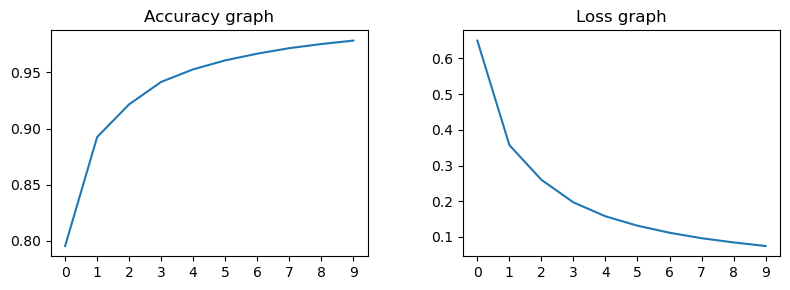

In [132]:
# Plotting the Accuracy and Loss graphs
plt.figure(figsize=(8,3))

ax1 = plt.subplot(1, 2, 1)
ax1.plot(train_accs)
ax1.set_title(f"Accuracy graph")
ax1.set_xticks(range(10))

ax1 = plt.subplot(1, 2, 2)
ax1.plot(train_losses)
ax1.set_title(f"Loss graph")
ax1.set_xticks(range(10))

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.show()

### Testing
Test our model on MNIST test dataset. We achieved a test accuracy of over 96%.

Plot the confusion matrix to obtain a better idea of how our model classifies the digits.

In [133]:
# Get test accuracy
y_pred, _ = predict(model, X_test, Y_test)
print(f"Test accuracy: {accuracy_score(Y_test, y_pred)*100}")

Test accuracy: 96.95


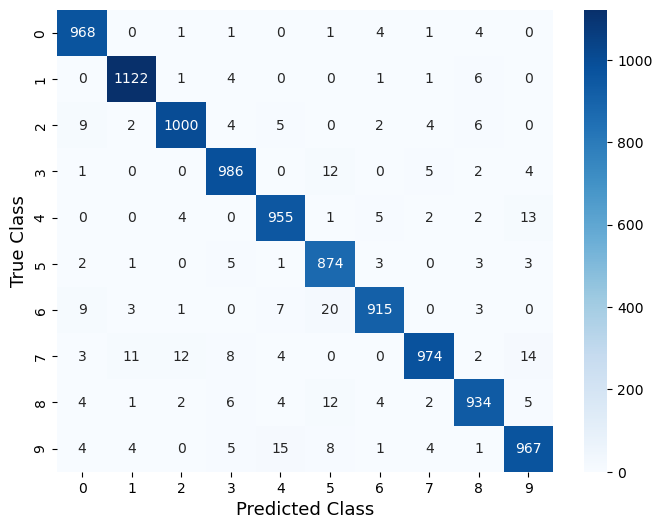

In [134]:
# Plot consfusion matrix
cm = confusion_matrix(Y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, annot_kws={'size':10}, xticklabels=np.arange(10), yticklabels=np.arange(10), cmap='Blues', fmt='g')
plt.xlabel('Predicted Class', fontsize=13)
plt.ylabel('True Class', fontsize=13)
plt.show(block=False)

Rochishnu Banerjee

banerjr2@miamioh.edu